#DSCI 417 – Project 03
##Forest Cover Prediction
**Adam Sneed**

In this project, we will be working with the Forest Cover dataset. Our goal will be to create a model to generate predictions about the type of forest cover in a particular
wilderness region based on cartographic information.

##Part A: Set up Environment
In this part of the project, we will import the required tool from pyspark, and will also create a SparkSession object.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

##Part B: Load and Explore the Data
In this part, we will be loading in the dataset and exploring differenct characteristics of it. We will begin by loading the dataset into a DataFrame.

In [0]:
forest_schema =  (
    'Elevation INT, Aspect INT, Slope INT, Horizontal_Distance_To_Hydrology INT, '
    'Vertical_Distance_To_Hydrology INT, Horizontal_Distance_To_Roadways INT, Hillshade_9am INT, '
    'Hillshade_Noon INT, Hillshade_3pm INT, Horizontal_Distance_To_Fire_Points INT, '
    'Wilderness_Area STRING, Soil_Type INT, Cover_Type INT'
)

fc = (
    spark
    .read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(forest_schema)
    .csv('/FileStore/tables/forest_cover.txt')
)

fc.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area: string (nullable = true)
 |-- Soil_Type: integer (nullable = true)
 |-- Cover_Type: integer (nullable = true)



In [0]:
column_names = fc.columns

first_six_columns = fc.select(column_names[:6])

first_six_columns.show(3)

remaining_columns = fc.select(column_names[6:])

remaining_columns.show(3)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
|     2596|    51|    3|                             258|                             0|                            510|
|     2590|    56|    2|                             212|                            -6|                            390|
|     2804|   139|    9|                             268|                            65|                           3180|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
only showing top 3 rows

+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
|Hillshade_

In [0]:
N = fc.count()

print("Number of records in the fc DataFrame:", N)

Number of records in the fc DataFrame: 15120


In [0]:
from pyspark.sql.functions import round

grouped_df = fc.groupBy("Cover_Type").count()

total_count = grouped_df.selectExpr("sum(count)").collect()[0][0]

proportion_df = grouped_df.withColumn("prop", round(grouped_df["count"] / total_count, 4))

proportion_df = proportion_df.select("Cover_Type", "prop")

proportion_df.show()

+----------+------+
|Cover_Type|  prop|
+----------+------+
|         1|0.1429|
|         6|0.1429|
|         3|0.1429|
|         5|0.1429|
|         4|0.1429|
|         7|0.1429|
|         2|0.1429|
+----------+------+



##Part C: Preprocessing and Splitting the Data

In [0]:
cat_features = ['Wilderness_Area', 'Soil_Type']
num_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler_lr = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_lr')

assembler_dt = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_dt')

In [0]:
pipeline = Pipeline(stages=[indexer, encoder, assembler_lr, assembler_dt]).fit(fc)
fc_proc = pipeline.transform(fc)
fc_proc.persist()

fc_proc.select(['features_dt', 'Cover_Type']).show(10, truncate=False)

+-----------------------------------------------------------------------+----------+
|features_dt                                                            |Cover_Type|
+-----------------------------------------------------------------------+----------+
|[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,2.0,1.0]     |5         |
|[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,2.0,1.0]    |5         |
|[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,2.0,20.0] |2         |
|[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,2.0,6.0]|2         |
|[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,2.0,1.0]    |5         |
|[2579.0,132.0,6.0,300.0,-15.0,67.0,230.0,237.0,140.0,6031.0,2.0,1.0]   |2         |
|[2606.0,45.0,7.0,270.0,5.0,633.0,222.0,225.0,138.0,6256.0,2.0,1.0]     |5         |
|[2605.0,49.0,4.0,234.0,7.0,573.0,222.0,230.0,144.0,6228.0,2.0,1.0]     |5         |
|[2617.0,45.0,9.0,240.0,56.0,666.0,223.0,221.0,133.0,6244.0,2.0,1

In [0]:
splits = fc_proc.randomSplit([0.8, 0.2], seed=1)
train = splits[0]
test = splits[1]

In [0]:
train.persist()

train_count = train.count()
test_count = test.count()

print(f"Training Observations: {train_count}")
print(f"Testing Observations: {test_count}")

Training Observations: 12118
Testing Observations: 3002


##Part D: Hyperparameter for Logistic Regression

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

In [0]:
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')

param_grid = (ParamGridBuilder()
    .addGrid(logreg.regParam, [0.0001, 0.001, 0.01, 0.1, 1])
    .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
    .build()
)
   
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                    numFolds=5, seed=1)

cv_model = cv.fit(train)

In [0]:
lr_model = cv_model.bestModel

opt_regParam = lr_model.getRegParam()
opt_enetParam = lr_model.getElasticNetParam()

print('Max CV Score:', "{:.4f}".format(max(cv_model.avgMetrics)))
print('Optimal Lambda:', "{:.4f}".format(opt_regParam))
print('Optimal Alpha:', "{:.4f}".format(opt_enetParam))

Max CV Score: 0.7001
Optimal Lambda: 0.0001
Optimal Alpha: 0.0000


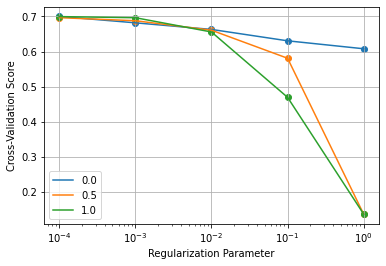

In [0]:
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list,
                            columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])
    
plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

##Part E: Hyperparameter Tuning for Decision Trees

In [0]:
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', seed=1, maxBins=38)

param_grid2 = (ParamGridBuilder()
             .addGrid(dtree.maxDepth, [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] )
             .addGrid(dtree.minInstancesPerNode, [1, 2, 4])
             .build())

cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid2, numFolds=5, 
                    evaluator=accuracy_eval, seed=1)

cv_model = cv.fit(train)

In [0]:
dt_model = cv_model.bestModel

opt_maxDepth = dt_model.getMaxDepth()
opt_minInstancesPerNode = dt_model.getMinInstancesPerNode()

print('Max CV Score:', "{:.4f}".format(max(cv_model.avgMetrics)))
print('Optimal Depth:', "{:.4f}".format(opt_maxDepth))
print('Optimal MinInst:', "{:.4f}".format(opt_minInstancesPerNode))

Max CV Score: 0.7775
Optimal Depth: 16.0000
Optimal MinInst: 1.0000


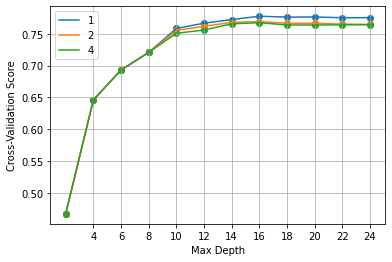

In [0]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list,
                            columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])

plt.legend()
plt.grid()
plt.xticks(range(4,26,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.show()

In [0]:
features = num_features + cat_features

pd.DataFrame({
    'feature':features,
    'importance':dt_model.featureImportances
})

,feature,importance
0,Elevation,"(0.39425992555333683, 0.0481157907154839, 0.02..."
1,Aspect,"(0.39425992555333683, 0.0481157907154839, 0.02..."
2,Slope,"(0.39425992555333683, 0.0481157907154839, 0.02..."
3,Horizontal_Distance_To_Hydrology,"(0.39425992555333683, 0.0481157907154839, 0.02..."
4,Vertical_Distance_To_Hydrology,"(0.39425992555333683, 0.0481157907154839, 0.02..."
5,Horizontal_Distance_To_Roadways,"(0.39425992555333683, 0.0481157907154839, 0.02..."
6,Hillshade_9am,"(0.39425992555333683, 0.0481157907154839, 0.02..."
7,Hillshade_Noon,"(0.39425992555333683, 0.0481157907154839, 0.02..."
8,Hillshade_3pm,"(0.39425992555333683, 0.0481157907154839, 0.02..."
9,Horizontal_Distance_To_Fire_Points,"(0.39425992555333683, 0.0481157907154839, 0.02..."


##Part F: Identifying and Evaluating the Final Model

The dt_model is better because it has a higher cross-validation score.

In [0]:
test_pred = dt_model.transform(train)
test_pred.select('probability', 'prediction', 'Cover_Type').show(10, truncate=False)

+---------------------------------------------------------------------------------+----------+----------+
|probability                                                                      |prediction|Cover_Type|
+---------------------------------------------------------------------------------+----------+----------+
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                                |6.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                                |6.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                                |6.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                                |6.0       |6         |
|[0.0,0.0,0.0,0.5714285714285714,0.047619047619047616,0.0,0.38095238095238093,0.0]|3.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                                |6.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]            

In [0]:
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))
metrics = MulticlassMetrics(pred_and_labels)
accuracy = metrics.accuracy
print(f"Accuracy: {accuracy:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Accuracy: 0.9674


In [0]:
confusion_matrix = metrics.confusionMatrix()

confusion_matrix_df = pd.DataFrame(confusion_matrix.toArray(), index=range(1, 8), columns=range(1, 8))

print(confusion_matrix_df)

        1       2       3       4       5       6       7
1  1641.0    37.0     0.0     0.0    16.0     2.0     7.0
2    46.0  1619.0     2.0     0.0    72.0    16.0     0.0
3     2.0     1.0  1622.0     2.0     5.0    97.0     0.0
4     0.0     0.0     5.0  1681.0     0.0     3.0     0.0
5     2.0     7.0     1.0     0.0  1740.0     4.0     0.0
6     0.0     2.0    50.0     3.0     4.0  1701.0     0.0
7     4.0     2.0     0.0     0.0     3.0     0.0  1719.0


Observations in the test set with Cover Type 6 were misclassified by the model as Cover Type 3 a total
of 97 times. This was the most common type of misclassification in the test set.

In [0]:
precision_recall_df = pd.DataFrame(columns=['Label', 'Precision', 'Recall'])

for label in range(1, 8):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    precision_recall_df = precision_recall_df.append({'Label': label, 'Precision': precision, 'Recall': recall}, ignore_index=True)

precision_recall_df = precision_recall_df.round(4)

print(precision_recall_df.to_string(index=False))

 Label  Precision  Recall
   1.0     0.9681  0.9636
   2.0     0.9706  0.9225
   3.0     0.9655  0.9381
   4.0     0.9970  0.9953
   5.0     0.9457  0.9920
   6.0     0.9331  0.9665
   7.0     0.9959  0.9948


Use the precision and recall results for the test set to answer the following questions in a markdown cell.
Provide justification for your answers.
1. Which cover type is most likely to be correctly classified by our final model? 
   Cover type 4
2. Which cover type is most likely to be misclassified by our final model? 
   Cover type 6
3. Which cover type has the greatest difference between its precision and recall? Explain the meaning of
both of these values with respect to this cover type. 
   Cover type 5 has the greatest difference between the two. Its recall is higher by about 5 meaning it was choosen more than it was supposed to be.